# TODO

* TensorBoard output

* Record best model callback

* Move to_categorical from preprocessing to generator fxn

* Make sliding window bigger

* Queue up examples from multiple files before yielidng a batch; enforce batch sizes always same

* Bidirectional LSTM

* BiLSTM with Attention

* Consider using simple_RNN library to do Attention model quickly

In [2]:
import glob
import os

import matplotlib.pyplot as plt

from IPython.display import SVG

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Concatenate, Input, GRU, LSTM, Dense, Masking, Dropout, Embedding, Flatten, Dense
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
import numpy as np
import pandas as pd

from sklearn.externals import joblib
from sklearn.utils import shuffle

# Config

In [3]:
SIG_DIGITS = 4
QUANTIZATION = 12  # smallest unit is 1/12 of a beat
MAX_EVENT_BEATS = 4

MIDI_MIN = 21
MIDI_MAX = 108

MAX_EVENT_SUBBEATS = QUANTIZATION * MAX_EVENT_BEATS

MIDI_LEN = MIDI_MAX - MIDI_MIN + 1  # 88 keys

# Adds a start command node for the Y data in timestep 0, to start off decoder. Also expands feature vector length.
ADD_START = True  

# One-hot vector lengths
NUM_COMMAND_CLASSES = 3
if ADD_START:
    NUM_COMMAND_CLASSES += 1

NUM_MIDI_CLASSES = MIDI_LEN + 1                # + 1 for "0" case
NUM_DURATION_CLASSES = MAX_EVENT_SUBBEATS + 1  # + 1 for "0" case

# Start of range is inclusive, end of range is exclusive. 
COMMAND_VEC_RANGE = (0, NUM_COMMAND_CLASSES)
MIDI_VEC_RANGE = (COMMAND_VEC_RANGE[1], COMMAND_VEC_RANGE[1] + NUM_MIDI_CLASSES)
DURATION_VEC_RANGE = (MIDI_VEC_RANGE[1], MIDI_VEC_RANGE[1] + NUM_DURATION_CLASSES)
VEC_LENGTH = DURATION_VEC_RANGE[1]
#COMMAND_VEC_RANGE, MIDI_VEC_RANGE, DURATION_VEC_RANGE, VEC_LENGTH

# Y values have an extra "start" command option. X values don't.
VEC_LENGTH_X = VEC_LENGTH
if ADD_START:
    VEC_LENGTH_X -= 1

INPUT_NOTES = 30
OUTPUT_NOTES = 10
SLIDING_WINDOW_NOTES = 5

INPUT_TIMESTEPS = 4 * INPUT_NOTES
OUTPUT_TIMESTEPS = 4 * OUTPUT_NOTES

# y values have an extra timestep if adding start symbol
if ADD_START:
    OUTPUT_TIMESTEPS += 1
    
SLIDING_WINDOW_TIMESTEPS = 4 * SLIDING_WINDOW_NOTES

In [4]:
NUM_LSTM_NODES = 1024             # Num of intermediate LSTM nodes
CONTEXT_VECTOR_SIZE = 256        # Size of context vector (num of LSTM nodes in final LSTM layer)

EMBEDDING_DIM = 100              # Embedding layer size for input words

BATCH_SIZE = 256
NUM_EPOCHS = 100

LR = 0.01
DROPOUT = 0.3

NUM_TRAINING_EXAMPLES = 2123241
NUM_TEST_EXAMPLES = 522691
NUM_STEPS_PER_EPOCH = int(np.ceil(NUM_TRAINING_EXAMPLES / BATCH_SIZE))
NUM_TEST_STEPS_PER_EPOCH = int(np.ceil(NUM_TEST_EXAMPLES / BATCH_SIZE))

In [5]:
NUM_STEPS_PER_EPOCH, NUM_TEST_STEPS_PER_EPOCH

(8294, 2042)

# Set up for Training

## Data generator

In [6]:
TRAIN_PATH = '/data/mirex2018/train_pkl/train*pkl'
TEST_PATH = '/data/mirex2018/test_pkl/test*pkl'

In [7]:
def load_dataset(pickle_filename):
    """Returns tuple of train_matrix, test_matrix, holding many examples.
    Ex: two matrix shapes returned: (561, 120, 141), (561, 40, 141).
    dims are: (example #, timestep, feature)
    """
    x_list, y_list = joblib.load(pickle_filename) 
    x, y = np.vstack(x_list), np.vstack(y_list)
    # Shuffle order of rows in tandem to keep inputs with outputs.
    return shuffle(x, y)

In [8]:
TRAIN_FILES = sorted(glob.glob(TRAIN_PATH))
TEST_FILES = sorted(glob.glob(TEST_PATH))

In [9]:
def example_generator(train=True):
    files = TRAIN_FILES if train else TEST_FILES
    
    while True:
        for file in shuffle(files):
            #print('new FILE!')
            x, y = load_dataset(file)
            
            if ADD_START:
                # Insert room for START data as feature 0
                y = np.concatenate((np.expand_dims(np.array([[0] * (OUTPUT_TIMESTEPS - 1)] * len(y)), axis=2), y), axis=2)
            
                # Insert START symbol (1 and then 0s) before each example in y data
                z = np.array([[[1] + [0] * (VEC_LENGTH - 1)]] * len(y)) 
                y = np.hstack((z, y))
            
            
            # Now create the desired data format for the encoder/decoder pieces: 
            #                INPUTS                             OUTPUTS (command, midi, duration one-hots)
            # ([encoder_input_data, decoder_input_data], [decoder_target_data1, decoder_target_data2, decoder_target_data3])
            
            y_shifted = y[:, 1:, :]
            decoder_target_data1 = y_shifted[:, :, COMMAND_VEC_RANGE[0]:COMMAND_VEC_RANGE[1]]
            decoder_target_data2 = y_shifted[:, :, MIDI_VEC_RANGE[0]:MIDI_VEC_RANGE[1]]
            decoder_target_data3 = y_shifted[:, :, DURATION_VEC_RANGE[0]:DURATION_VEC_RANGE[1]]
            
            for i in range(0, len(x), BATCH_SIZE):
                #print('new batch')
                j = i + BATCH_SIZE
                yield ([x[i: j], y[i: j, :-1]], 
                       [decoder_target_data1[i: j], decoder_target_data2[i: j], decoder_target_data3[i: j]])

In [10]:
training_generator = example_generator()
validation_generator = example_generator(False)

## Utils

In [11]:
def plot_matrix(x):
    plt.figure(figsize=(20,10))
    plt.imshow(x, origin='lower')
    plt.show()

In [12]:
X,Y = next(training_generator)

In [13]:
[X[0].shape, X[1].shape], [Y[0].shape, Y[1].shape, Y[2].shape]

([(256, 120, 141), (256, 40, 142)],
 [(256, 40, 4), (256, 40, 89), (256, 40, 49)])

## Build Model

In [14]:
# Build RNN model.
# See also: https://machinelearningmastery.com/define-encoder-decoder-sequence-sequence-model-neural-machine-translation-keras/

encoding_size = CONTEXT_VECTOR_SIZE
max_input_seq_len = INPUT_TIMESTEPS
max_output_seq_len = OUTPUT_TIMESTEPS
# num_input_words = num_words_X
# num_output_words = num_words_y

encoder_inputs = Input(shape=(max_input_seq_len, VEC_LENGTH_X), name='encoder_input')
#encoder_inputs_masked = Masking(mask_value=0, name='encoder_masking')(encoder_inputs)
#encoder_inputs_embedded = Embedding(VEC_LENGTH_X, EMBEDDING_DIM, name='encoder_embedding')(encoder_inputs)
encoder_outputs1, state_h1, state_c1 = LSTM(NUM_LSTM_NODES, return_sequences=True, return_state=True,
                                            name='encoder_lstm_1')(encoder_inputs)
encoder_outputs2, state_h2, state_c2 = LSTM(NUM_LSTM_NODES, return_sequences=False, return_state=True,
                                            name='encoder_lstm_2')(encoder_outputs1)

# Discard `encoder_outputs` and only keep the states.
encoder_states1 = [state_h1, state_c1]
encoder_states2 = [state_h2, state_c2]

In [15]:
# Decoder section
# Set up the decoder, using encoder_states as initial state.
decoder_inputs = Input(shape=(None, VEC_LENGTH), name='decoder_input')
#decoder_inputs_masked = Masking(mask_value=0, name='decoder_masking')(decoder_inputs)
#decoder_inputs_embedded = Embedding(num_output_words, EMBEDDING_DIM, mask_zero=True, 
#                                    name='decoder_embedding')(decoder_inputs_masked)
decoder_lstm1 = LSTM(NUM_LSTM_NODES, return_sequences=True, return_state=True, name='decoder_lstm_1')
z1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states1)
decoder_lstm2 = LSTM(NUM_LSTM_NODES, return_sequences=True, return_state=True, name='decoder_lstm_2')
z2, _, _ = decoder_lstm2(z1, initial_state=encoder_states2)

decoder_dense1 = Dense(NUM_COMMAND_CLASSES, activation='softmax', name='decoder_output_command')
decoder_dense2 = Dense(NUM_MIDI_CLASSES, activation='softmax', name='decoder_output_midi')
decoder_dense3 = Dense(NUM_DURATION_CLASSES, activation='softmax', name='decoder_output_duration')
decoder_outputs1 = decoder_dense1(z2)
decoder_outputs2 = decoder_dense2(z2)
decoder_outputs3 = decoder_dense3(z2)

In [16]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], [decoder_outputs1, decoder_outputs2, decoder_outputs3])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 120, 141)     0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None, 142)    0                                            
__________________________________________________________________________________________________
encoder_lstm_1 (LSTM)           [(None, 120, 1024),  4775936     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, None, 1024), 4780032     decoder_input[0][0]              
                                                                 encoder_lstm_1[0][1]             
          

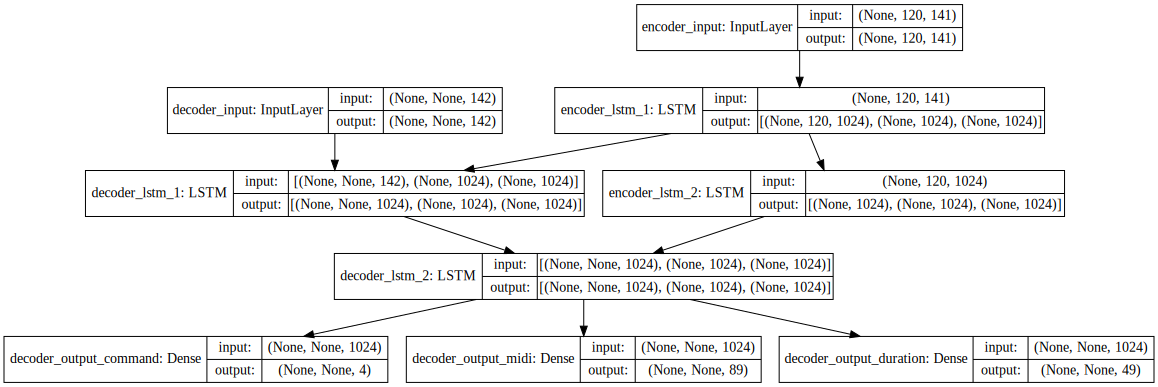

In [17]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Train

In [18]:
# encoder_input_data = X_train
# decoder_input_data = y_train

# # decoder_target_data will be ahead by one timestep
# # and will not include the start token.
# decoder_target_data = np.zeros(y_train_one_hot.shape)
# decoder_target_data[:,:-1] = y_train_one_hot[:,1:,:]
                                             
# decoder_target_data_test = np.zeros(y_test_one_hot.shape)
# decoder_target_data_test[:,:-1] = y_test_one_hot[:,1:,:]

In [19]:
optimizer = Adam(lr=.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [20]:
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, mode='auto', 
                                cooldown=0, min_lr=0)

In [21]:
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [22]:
# Run training
model.fit_generator(training_generator, steps_per_epoch=NUM_STEPS_PER_EPOCH/50,
                    validation_data=validation_generator, 
                    validation_steps=NUM_TEST_STEPS_PER_EPOCH/50, 
                    verbose=1,
                    workers=1,
                    use_multiprocessing=False,
                    epochs=NUM_EPOCHS,
                    callbacks=[lr_callback, early_stopping_callback])

Epoch 1/100
166/165 [==============================] - 240s 1s/step - loss: 4.3445 - decoder_output_command_loss: 0.6232 - decoder_output_midi_loss: 2.3903 - decoder_output_duration_loss: 1.3310 - val_loss: 3.6682 - val_decoder_output_command_loss: 0.3649 - val_decoder_output_midi_loss: 2.1884 - val_decoder_output_duration_loss: 1.1149
Epoch 2/100
166/165 [==============================] - 229s 1s/step - loss: 2.9971 - decoder_output_command_loss: 0.0997 - decoder_output_midi_loss: 1.9903 - decoder_output_duration_loss: 0.9071 - val_loss: 3.1421 - val_decoder_output_command_loss: 0.0366 - val_decoder_output_midi_loss: 2.1657 - val_decoder_output_duration_loss: 0.9398
Epoch 3/100
166/165 [==============================] - 232s 1s/step - loss: 2.8259 - decoder_output_command_loss: 0.0227 - decoder_output_midi_loss: 2.0143 - decoder_output_duration_loss: 0.7888 - val_loss: 3.0328 - val_decoder_output_command_loss: 0.0176 - val_decoder_output_midi_loss: 2.2413 - val_decoder_output_duration

166/165 [==============================] - 233s 1s/step - loss: 1.2223 - decoder_output_command_loss: 0.0017 - decoder_output_midi_loss: 0.6686 - decoder_output_duration_loss: 0.5521 - val_loss: 1.4801 - val_decoder_output_command_loss: 6.0395e-04 - val_decoder_output_midi_loss: 0.7359 - val_decoder_output_duration_loss: 0.7436
Epoch 26/100
166/165 [==============================] - 232s 1s/step - loss: 1.3126 - decoder_output_command_loss: 0.0012 - decoder_output_midi_loss: 0.6792 - decoder_output_duration_loss: 0.6322 - val_loss: 1.4062 - val_decoder_output_command_loss: 0.0015 - val_decoder_output_midi_loss: 0.7823 - val_decoder_output_duration_loss: 0.6223
Epoch 27/100
166/165 [==============================] - 231s 1s/step - loss: 1.1869 - decoder_output_command_loss: 0.0013 - decoder_output_midi_loss: 0.6371 - decoder_output_duration_loss: 0.5485 - val_loss: 1.3894 - val_decoder_output_command_loss: 0.0023 - val_decoder_output_midi_loss: 0.7584 - val_decoder_output_duration_loss:

Epoch 48/100
166/165 [==============================] - 232s 1s/step - loss: 1.0244 - decoder_output_command_loss: 9.1148e-04 - decoder_output_midi_loss: 0.5696 - decoder_output_duration_loss: 0.4539 - val_loss: 1.1344 - val_decoder_output_command_loss: 2.8292e-04 - val_decoder_output_midi_loss: 0.6078 - val_decoder_output_duration_loss: 0.5263
Epoch 49/100
166/165 [==============================] - 232s 1s/step - loss: 1.0611 - decoder_output_command_loss: 5.6370e-04 - decoder_output_midi_loss: 0.6115 - decoder_output_duration_loss: 0.4490 - val_loss: 1.1249 - val_decoder_output_command_loss: 9.4439e-04 - val_decoder_output_midi_loss: 0.6482 - val_decoder_output_duration_loss: 0.4758
Epoch 50/100
166/165 [==============================] - 233s 1s/step - loss: 1.0981 - decoder_output_command_loss: 0.0011 - decoder_output_midi_loss: 0.5959 - decoder_output_duration_loss: 0.5012 - val_loss: 1.1403 - val_decoder_output_command_loss: 4.0804e-04 - val_decoder_output_midi_loss: 0.6436 - val_

In [23]:
# Save model
model.save('s2s.h5')

/home/eric/anaconda3/envs/mirex2018/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_lstm_1 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_1/while/Exit_3:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'encoder_lstm_1/while/Exit_4:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/home/eric/anaconda3/envs/mirex2018/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer decoder_lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_4:0' shape=(?, 1024) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Run Model

In [24]:
# Define sampling models
encoder_model1 = Model(encoder_inputs, encoder_states1)
encoder_model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 120, 141)          0         
_________________________________________________________________
encoder_lstm_1 (LSTM)        [(None, 120, 1024), (None 4775936   
Total params: 4,775,936
Trainable params: 4,775,936
Non-trainable params: 0
_________________________________________________________________


In [25]:
encoder_model2 = Model(encoder_inputs, encoder_states2)
encoder_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 120, 141)          0         
_________________________________________________________________
encoder_lstm_1 (LSTM)        [(None, 120, 1024), (None 4775936   
_________________________________________________________________
encoder_lstm_2 (LSTM)        [(None, 1024), (None, 102 8392704   
Total params: 13,168,640
Trainable params: 13,168,640
Non-trainable params: 0
_________________________________________________________________


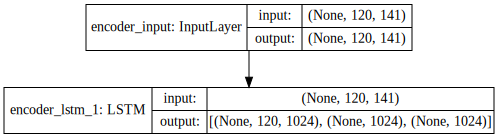

In [26]:
SVG(model_to_dot(encoder_model1, show_shapes=True).create(prog='dot', format='svg'))

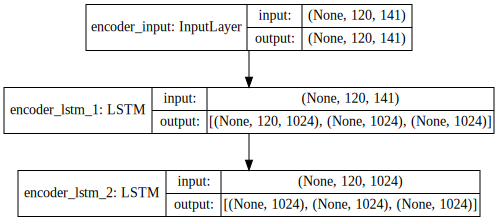

In [27]:
SVG(model_to_dot(encoder_model2, show_shapes=True).create(prog='dot', format='svg'))

In [28]:
decoder_state_input_h1 = Input(shape=(NUM_LSTM_NODES,), name='inference_decoder_h1')
decoder_state_input_c1 = Input(shape=(NUM_LSTM_NODES,), name='inference_decoder_c1')
decoder_state_input_h2 = Input(shape=(NUM_LSTM_NODES,), name='inference_decoder_h2')
decoder_state_input_c2 = Input(shape=(NUM_LSTM_NODES,), name='inference_decoder_c2')
decoder_states_inputs1 = [decoder_state_input_h1, decoder_state_input_c1]
decoder_states_inputs2 = [decoder_state_input_h2, decoder_state_input_c2]

#decoder_inputs_inference = Input(shape=(None, VEC_LENGTH), name='decoder_input_inference')

zz1 = decoder_lstm1(decoder_inputs, initial_state=decoder_states_inputs1)
decoder_outputs1new, decoder_state_h1, decoder_state_c1 = zz1
#decoder_states_inputs2 = [decoder_state_h1, decoder_state_c1]

zz2 = decoder_lstm2(decoder_outputs1new, initial_state=decoder_states_inputs2)


decoder_outputs2new, decoder_state_h2, decoder_state_c2 = zz2

decoder_states1 = [decoder_state_h1, decoder_state_c1]
decoder_states2 = [decoder_state_h2, decoder_state_c2]
decoder_outputs_final1 = decoder_dense1(decoder_outputs2new)
decoder_outputs_final2 = decoder_dense2(decoder_outputs2new)
decoder_outputs_final3 = decoder_dense3(decoder_outputs2new)

decoder_model = Model([decoder_inputs] + decoder_states_inputs1 + decoder_states_inputs2,
                      [decoder_outputs_final1, decoder_outputs_final2, decoder_outputs_final3] + decoder_states1 + decoder_states2)
decoder_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      (None, None, 142)    0                                            
__________________________________________________________________________________________________
inference_decoder_h1 (InputLaye (None, 1024)         0                                            
__________________________________________________________________________________________________
inference_decoder_c1 (InputLaye (None, 1024)         0                                            
__________________________________________________________________________________________________
decoder_lstm_1 (LSTM)           [(None, None, 1024), 4780032     decoder_input[0][0]              
                                                                 inference_decoder_h1[0][0]       
          

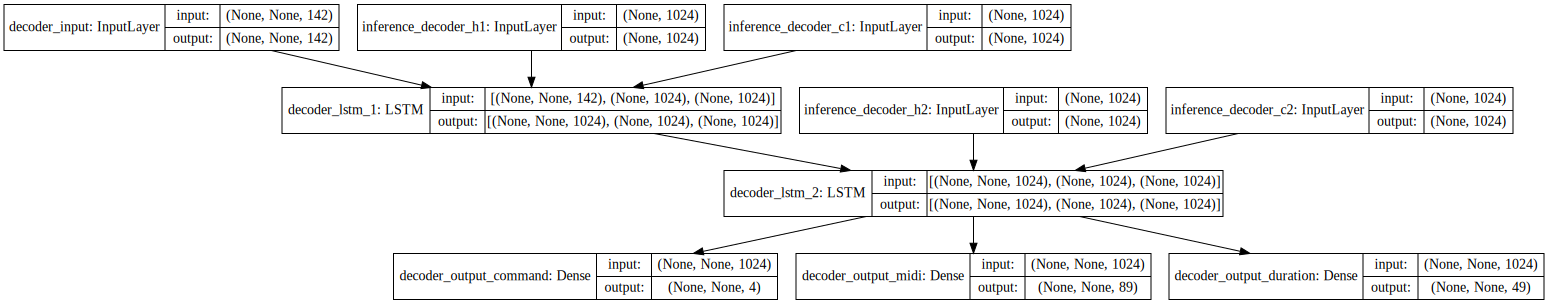

In [29]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

In [30]:
def seq2seq(input_seq):
    # Encode the input as state vectors.
    h1, c1 = encoder_model1.predict(input_seq)
    states_value1 = [h1, c1]
    h2, c2 = encoder_model2.predict(input_seq)
    states_value2 = [h2, c2]
    
    # Generate first input: Start vector.
    target_seq = np.zeros((1,VEC_LENGTH))
    target_seq[0,0] = 1  # first element is "1" to indicate "start"
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    output_sequence = []
    step = 0
    while step < OUTPUT_TIMESTEPS: 
        z = decoder_model.predict(
            [np.expand_dims(target_seq, 0)] + states_value1 + states_value2)
        out_vec1, out_vec2, out_vec3, h1, c1, h2, c2 = z
        
        sampled_command = np.argmax(out_vec1[0, 0, :])
        sampled_midi = np.argmax(out_vec2[0, 0, :])
        sampled_dur = np.argmax(out_vec3[0, 0, :])
        
        #print(sampled_command, sampled_midi, sampled_dur)
        output_sequence.append((sampled_command, sampled_midi, sampled_dur))
        step += 1
        
        # Exit condition: either hit max length
        # or find stop character.
        #if (sampled_word == '</S>' or step > max_output_seq_len):
        #    stop_condition = True

        # Update the target sequence (of length 1).
        
        target_seq = np.zeros((1,VEC_LENGTH))
        target_seq[0, sampled_command] = 1
        target_seq[0, MIDI_VEC_RANGE[0] + sampled_midi] = 1
        target_seq[0, DURATION_VEC_RANGE[0] + sampled_dur] = 1
        
        # Update states
        states_value1 = [h1, c1]
        states_value2 = [h2, c2]
        
    return output_sequence

In [31]:
[x, y], [target1, target2, target3] = next(training_generator)

In [32]:
if False:
    train = False
    files = TRAIN_FILES if train else TEST_FILES

    sum = 0 
    for i, file in enumerate(files):
        x, y = joblib.load(file)
        if i % 10 == 0:
            print(i)
        for yy in y:
            print(yy.shape[0])
            sum += yy.shape[0]
    sum

# Convert Output to CSV and MIDI

In [33]:
QUANTIZATION = 12  # smallest unit is 1/12 of a beat
MAX_EVENT_BEATS = 4

SIG_FIGS = 5

MIDI_MIN = 21
MIDI_MAX = 108

MAX_EVENT_SUBBEATS = QUANTIZATION * MAX_EVENT_BEATS

In [34]:
pc_to_degree_flat_key = [0, 1, 1, 2, 2, 3, 4, 4, 5, 5, 6, 6]
pc_to_degree_sharp_key = [0, 0, 1, 1, 2, 3, 3, 4, 4, 5, 5, 6]

def midi_to_mnn(midi, flat_key=True):
    octave = 3 + midi // 12
    pc = midi % 12
    pc_to_degree = pc_to_degree_flat_key if flat_key else pc_to_degree_sharp_key
    degree = pc_to_degree[pc]
    return octave * 7 + degree + 4

In [35]:
def seq_to_tuples(seq, start_time=100, channel=0, flat_key=True):
    t = start_time  # time in beats, integer
    subbeat = 0 # curent subbeat in beat for t, range is 0 to QUANTIZATION-1
    
    notes = []
    
    cur_note_start = 0
    cur_note = None
    cur_dur = None
    
    for command, midi, dur in seq:
        mnn = midi_to_mnn(midi, flat_key)
        # Time-shift
        if command == 3:
            # Record note/rest start data.
            cur_dur = dur
            cur_note_start = round(t + subbeat / QUANTIZATION, SIG_FIGS)

            # Update current time.
            subbeat += dur
            if subbeat > QUANTIZATION:
                subbeat = dur % QUANTIZATION
                t += dur // QUANTIZATION + 1
        
        # Note on.
        elif command == 2:
            if cur_note:
                notes.append((cur_note_start, midi, mnn, 
                              round(cur_dur/QUANTIZATION, SIG_FIGS), channel))
            cur_note = midi + MIDI_MIN - 1  # -1 for the 0 case

        # Note off.
        elif command == 1:
            if cur_note:
                notes.append((cur_note_start, midi, mnn, 
                              round(cur_dur/QUANTIZATION, SIG_FIGS), channel))
            cur_note = 0
    return notes
            

In [36]:
seq = seq2seq(np.expand_dims(x[1], axis=0))

In [37]:
seq_to_tuples(seq)

[(100.25, 23, 38, 0.16667, 0),
 (100.5, 23, 38, 0.16667, 0),
 (100.75, 23, 38, 0.16667, 0),
 (101.0, 23, 38, 0.16667, 0),
 (101.25, 23, 38, 0.16667, 0),
 (101.5, 23, 38, 0.16667, 0),
 (101.75, 23, 38, 0.16667, 0),
 (102.0, 23, 38, 0.16667, 0),
 (102.25, 23, 38, 0.16667, 0)]

In [38]:
def print_tuples(tuples):
    for t in tuples:
        print(t)

In [39]:
[x, y], [target1, target2, target3] = next(training_generator)

In [41]:
def target_outputs_to_seq(N, target1, target2, target3):
    return list(zip(np.argmax(target1[N], axis=1), 
                    np.argmax(target2[N], axis=1), 
                    np.argmax(target3[N], axis=1)))

In [42]:
def target_outputs_to_tuples(N, target1, target2, target3):
    return seq_to_tuples(target_outputs_to_seq(N, target1, target2, target3))

In [43]:
def seq_to_csv(seq, filename='tst.csv'):
    with open(filename, 'w') as f:
        f.writelines(','.join(str(x) for x in tup) + '\n' for tup in seq_to_tuples(seq))

In [44]:
for i in range(2):
    seq = seq2seq(np.expand_dims(x[i], axis=0))
    print('Output:')
    print_tuples(seq_to_tuples(seq))
    target_tuples = target_outputs_to_tuples(i, target1, target2, target3)
    print()
    print('prev should have been (target):')
    print_tuples(target_tuples)
    print('===============\n')

Output:
(100.16667, 23, 38, 0.33333, 0)
(100.66667, 23, 38, 0.33333, 0)
(101.16667, 23, 38, 0.33333, 0)
(101.66667, 23, 38, 0.33333, 0)
(102.16667, 23, 38, 0.33333, 0)
(102.66667, 23, 38, 0.33333, 0)
(103.16667, 23, 38, 0.33333, 0)
(103.66667, 23, 38, 0.33333, 0)
(104.16667, 23, 38, 0.33333, 0)
(104.66667, 23, 38, 0.33333, 0)

prev should have been (target):
(100.83333, 18, 36, 0.16667, 0)
(101.83333, 23, 38, 0.16667, 0)
(102.83333, 18, 36, 0.5, 0)
(103.5, 19, 36, 0.5, 0)
(104.0, 20, 37, 0.16667, 0)
(105.0, 15, 34, 0.16667, 0)
(106.0, 20, 37, 0.16667, 0)
(107.0, 15, 34, 0.16667, 0)
(108.0, 23, 38, 0.16667, 0)
(109.0, 18, 36, 0.16667, 0)

Output:
(100.5, 18, 36, 0.5, 0)
(101.0, 18, 36, 0.5, 0)
(101.5, 18, 36, 0.5, 0)
(102.0, 18, 36, 0.5, 0)
(102.5, 18, 36, 0.5, 0)
(103.0, 18, 36, 0.5, 0)
(103.5, 18, 36, 0.5, 0)
(104.0, 18, 36, 0.5, 0)
(104.5, 18, 36, 0.5, 0)

prev should have been (target):
(100.5, 17, 35, 0.5, 0)
(101.08333, 12, 32, 0.16667, 0)
(101.33333, 17, 35, 0.5, 0)
(102.0, 12, 3

In [46]:
seq_to_csv(seq)